In [13]:
# Imports
import precipgen as pg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
try:
    from scipy import stats
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False
print('PrecipGen version:', getattr(pg, '__version__', 'unknown'))
print('Scipy available:', SCIPY_AVAILABLE)

PrecipGen version: 0.1.4
Scipy available: True


In [14]:
# 1. Load Sea-Tac historical precipitation
latitude = 47.4502
longitude = -122.3088
stations = pg.find_nearby_stations(latitude=latitude, longitude=longitude, radius_km=25, min_years=15)
stations_df = pd.DataFrame(stations)
print('Stations columns:', list(stations_df.columns))
display(stations_df.head())
# pick station id robustly
_id_cols = ['station_id','id','ghcn_id','station']
for c in _id_cols:
    if c in stations_df.columns:
        station_id = stations_df.iloc[0][c]
        break
else:
    raise KeyError(f'No station id column found. columns: {list(stations_df.columns)}')
print('Using station:', station_id)
downloader = pg.GHCNDownloader(cache_dir='data')
dly_path = downloader.download_station_data(station_id)
parser = pg.GHCNParser(dly_path)
ghcn_data = parser.parse_dly_file(dly_path)
precip = parser.extract_precipitation(ghcn_data).sort_index().astype(float)
print('Historical length:', len(precip))

2025-12-21 12:58:15,080 - precipgen.ghcn_downloader - INFO - find_stations_by_location:67 - Searching for stations near 47.4502, -122.3088
2025-12-21 12:58:15,081 - precipgen.ghcn_downloader - INFO - _get_stations_metadata:319 - Loading GHCN stations metadata
2025-12-21 12:58:15,082 - precipgen.ghcn_downloader - INFO - _get_stations_metadata:325 - Using cached stations metadata
2025-12-21 12:58:15,242 - precipgen.ghcn_downloader - INFO - _get_inventory_metadata:344 - Loading GHCN inventory metadata
2025-12-21 12:58:15,243 - precipgen.ghcn_downloader - INFO - _get_inventory_metadata:350 - Using cached inventory metadata
2025-12-21 12:58:17,329 - precipgen.ghcn_downloader - INFO - find_stations_by_location:116 - Found 26 stations with 15+ years of precipitation data
Stations columns: ['id', 'name', 'latitude', 'longitude', 'elevation_m', 'distance_km', 'first_year', 'last_year', 'years_available']


,id,name,latitude,longitude,elevation_m,distance_km,first_year,last_year,years_available
0,USW00024233,SEATTLE TACOMA AP,47.4447,-122.3144,112.5,0.742529,1948,2025,78
1,USC00454169,KENT,47.4172,-122.2433,8.8,6.143065,1912,2023,112
2,US1WAKG0081,RENTON 0.5 SSW,47.4752,-122.2019,64.6,8.503486,2008,2025,18
3,USW00094248,RENTON MUNI AP,47.4950,-122.2144,5.5,8.669373,1998,2025,28
4,US1WAKG0041,RENTON 3.6 SSE,47.4332,-122.1704,124.1,10.578712,2008,2025,18


Using station: USW00024233
2025-12-21 12:58:17,369 - precipgen.ghcn_downloader - INFO - download_station_data:204 - Using cached file: data\USW00024233.dly
Historical length: 28443


In [15]:
# 2. Monthly parameters (used by WGEN)
threshold = 0.1
rows = []
for m in range(1,13):
    s = precip[precip.index.month==m]
    if len(s)==0:
        rows.append({'month':m,'p_w':np.nan,'p_ww':np.nan,'p_dw':np.nan,'alpha':np.nan,'beta':np.nan,'pos_n':0})
        continue
    is_w = (s>threshold).astype(int)
    p_w = is_w.mean()
    arr = is_w.values.astype(int)
    if len(arr)>1:
        prev, nxt = arr[:-1], arr[1:]
        p_ww = ((prev==1)&(nxt==1)).sum() / (prev==1).sum() if (prev==1).sum()>0 else np.nan
        p_dw = ((prev==0)&(nxt==1)).sum() / (prev==0).sum() if (prev==0).sum()>0 else np.nan
    else:
        p_ww=np.nan; p_dw=np.nan
    pos = s[s>threshold].dropna()
    if len(pos)>1:
        mpos = pos.mean(); vpos = pos.var(ddof=1)
        alpha = (mpos*mpos)/vpos if vpos>0 else np.nan
        beta = vpos/mpos if mpos>0 else np.nan
    else:
        alpha=np.nan; beta=np.nan
    rows.append({'month':m,'p_w':p_w,'p_ww':p_ww,'p_dw':p_dw,'alpha':alpha,'beta':beta,'pos_n':len(pos)})
monthly_df = pd.DataFrame(rows).set_index('month')
display(monthly_df.round(4))

,p_w,p_ww,p_dw,alpha,beta,pos_n
month,,,,,,
1,0.6017,0.7655,0.3541,0.7486,10.3981,1455
2,0.5613,0.7348,0.3385,0.6390,10.0789,1237
3,0.5509,0.6950,0.3738,0.7483,7.6673,1332
4,0.4747,0.6108,0.3512,0.6526,7.3513,1097
5,0.3515,0.5430,0.2474,0.6926,6.0097,850
6,0.2990,0.5207,0.2045,0.5887,6.9911,699
7,0.1510,0.3945,0.1077,0.6907,5.2452,365
8,0.1873,0.4702,0.1222,0.5129,8.8488,453
9,0.2933,0.5489,0.1875,0.6294,8.1795,686


In [16]:
# 3. Simulation helpers (compact)
def sim_dates(start='2026-01-01', end='2030-12-31'):
    return pd.date_range(start=start, end=end, freq='D')

def bootstrap_dayofyear(series, dates, n_sims=20, seed=None):
    rng = np.random.default_rng(seed)
    pools = {}
    for d, v in series.dropna().items():
        pools.setdefault((d.month,d.day), []).append(v)
    sims = np.empty((len(dates), n_sims))
    for i, d in enumerate(dates):
        pool = pools.get((d.month,d.day)) or [x for (mo,day),arr in pools.items() if mo==d.month for x in arr] or list(series.dropna().values)
        sims[i,:] = rng.choice(pool, size=n_sims, replace=True)
    return pd.DataFrame(sims, index=dates)


def block_bootstrap(series, dates, block_len=7, n_sims=20, seed=None, preserve_month=False, preserve_doy=False):
    """
    Block bootstrap. If preserve_month=True, sample block starts where the historical start month
    matches the target block-start month. If preserve_doy=True, prefer historical start positions that
    match the exact month/day of the target start (stronger seasonal preservation).
    """
    rng = np.random.default_rng(seed)
    vals = series.dropna().values
    idx = np.array([d for d in series.dropna().index])
    N = len(vals)
    sims = np.empty((len(dates), n_sims))

    # Precompute valid start positions
    starts = np.arange(0, max(1, N - block_len + 1))
    starts_by_month = {}
    starts_by_doy = {}
    for s in starts:
        mo = idx[s].month
        doy = (idx[s].month, idx[s].day)
        starts_by_month.setdefault(mo, []).append(s)
        starts_by_doy.setdefault(doy, []).append(s)

    blocks_needed = int(np.ceil(len(dates)/block_len))
    for sim in range(n_sims):
        out = []
        for b in range(blocks_needed):
            target_pos = b * block_len
            target_date = dates[target_pos]
            if preserve_doy:
                pool = starts_by_doy.get((target_date.month, target_date.day), [])
            elif preserve_month:
                pool = starts_by_month.get(target_date.month, starts)
            else:
                pool = starts
            if len(pool) == 0:
                start = int(rng.integers(0, max(1, N - block_len + 1)))
            else:
                start = int(rng.choice(pool))
            out.extend(vals[start:start+block_len].tolist())
        sims[:, sim] = out[:len(dates)]
    return pd.DataFrame(sims, index=dates)


def wgen_simulate(monthly_df, dates, n_sims=20, seed=None, nonstationary=None):
    rng = np.random.default_rng(seed)
    sims = np.zeros((len(dates), n_sims))
    for sim in range(n_sims):
        prev = None
        for i, d in enumerate(dates):
            mo = d.month
            p_w = monthly_df.loc[mo,'p_w']
            p_ww = monthly_df.loc[mo,'p_ww']
            p_dw = monthly_df.loc[mo,'p_dw']
            alpha = monthly_df.loc[mo,'alpha']
            beta = monthly_df.loc[mo,'beta']
            if nonstationary is not None:
                adj = nonstationary[i]
                p_w = p_w * adj.get('p_w_factor',1.0) if pd.notna(p_w) else p_w
                alpha = alpha * adj.get('alpha_factor',1.0) if pd.notna(alpha) else alpha
                beta = beta * adj.get('beta_factor',1.0) if pd.notna(beta) else beta
            if prev is None:
                wet = rng.random() < (p_w if pd.notna(p_w) else 0.1)
            else:
                prob = (p_ww if prev else p_dw) if pd.notna(p_ww) and pd.notna(p_dw) else (p_w if pd.notna(p_w) else 0.1)
                wet = rng.random() < prob
            if wet:
                if pd.notna(alpha) and pd.notna(beta) and alpha>0 and beta>0:
                    amt = rng.gamma(alpha, beta)
                else:
                    pool = precip[precip.index.month==mo].dropna().values
                    amt = float(rng.choice(pool)) if len(pool)>0 else 0.0
            else:
                amt = 0.0
            sims[i,sim] = amt
            prev = wet
    return pd.DataFrame(sims, index=dates)


In [17]:
# 4. Run simulations (reduced default ensemble for speed)
start='2026-01-01'; end='2030-12-31'
dates = sim_dates(start,end)
n_sims = 20  # reduced default for speed; increase as needed
boots = bootstrap_dayofyear(precip, dates, n_sims=n_sims, seed=42)
# preserve day-of-year for block bootstrap so seasonality is preserved
blocks = block_bootstrap(precip, dates, block_len=7, n_sims=n_sims, seed=1, preserve_doy=True)
wgen_s = wgen_simulate(monthly_df, dates, n_sims=n_sims, seed=24, nonstationary=None)
# simple nonstationary trend: increase wet-day probability and gamma scale by 10% linearly over period
frac = np.linspace(0,1,len(dates))
nonstat = [{'p_w_factor':1+0.10*f,'alpha_factor':1.0,'beta_factor':1+0.10*f} for f in frac]
wgen_ns = wgen_simulate(monthly_df, dates, n_sims=n_sims, seed=99, nonstationary=nonstat)
print('Done')

Done



 Bootstrap :


,mean_annual,std_annual
2026-12-31,952.6,85.0
2027-12-31,1000.4,108.1
2028-12-31,983.0,107.2
2029-12-31,963.3,136.8
2030-12-31,999.3,82.5


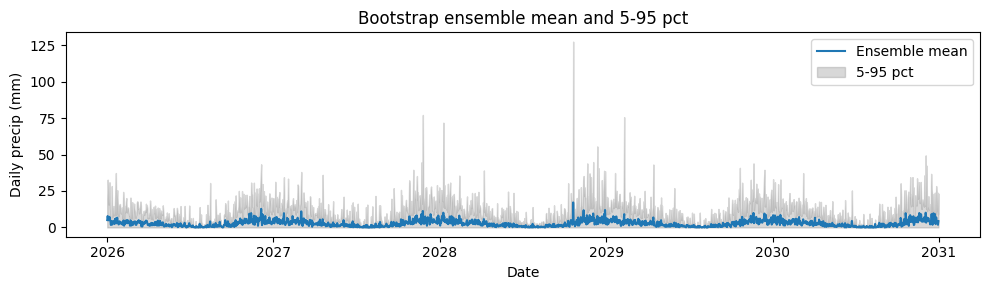


 Block :


,mean_annual,std_annual
2026-12-31,990.5,178.3
2027-12-31,1003.5,143.0
2028-12-31,1013.2,139.1
2029-12-31,1050.8,174.2
2030-12-31,964.4,85.1


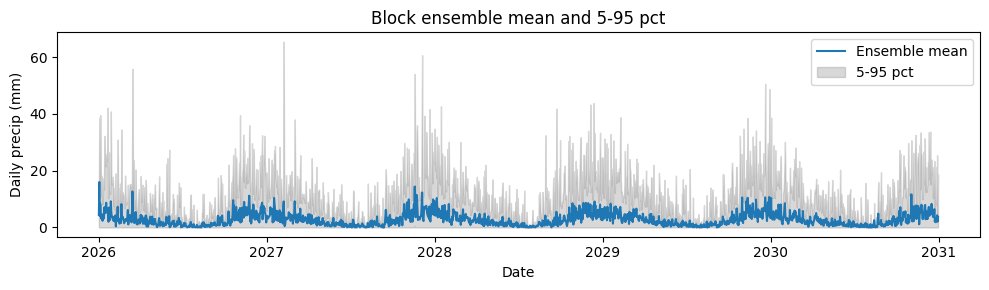


 WGEN_stat :


,mean_annual,std_annual
2026-12-31,982.2,141.5
2027-12-31,987.0,162.3
2028-12-31,994.3,138.2
2029-12-31,959.4,127.7
2030-12-31,957.0,140.7


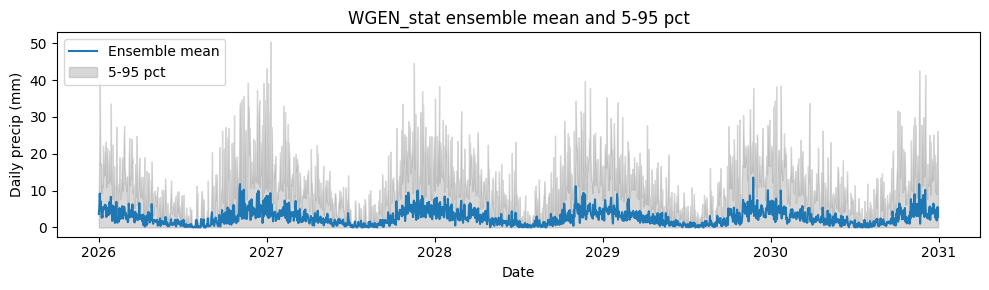


 WGEN_nonstat :


,mean_annual,std_annual
2026-12-31,955.5,103.5
2027-12-31,988.3,145.8
2028-12-31,1059.3,95.7
2029-12-31,1094.1,191.3
2030-12-31,1071.7,144.4


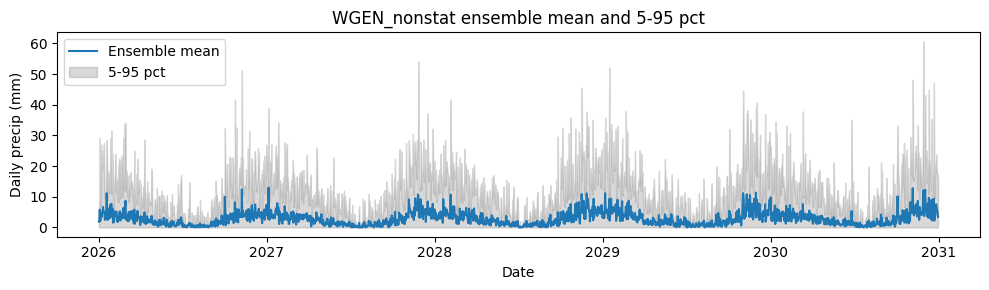

In [19]:
# 5. Quick summaries and plots
def annual_stats(df):
    ann = df.resample('YE').sum()
    return ann, ann.mean(axis=1), ann.std(axis=1)

for name, df in [('Bootstrap',boots),('Block',blocks),('WGEN_stat',wgen_s),('WGEN_nonstat',wgen_ns)]:
    ann, mean_ann, std_ann = annual_stats(df)
    print('\n',name,':')
    display(pd.DataFrame({'mean_annual':mean_ann, 'std_annual':std_ann}).round(1))
    mean_ts = df.mean(axis=1)
    q05 = df.quantile(0.05, axis=1); q95 = df.quantile(0.95, axis=1)
    plt.figure(figsize=(10,3))
    plt.plot(mean_ts.index, mean_ts.values, label='Ensemble mean')
    plt.fill_between(mean_ts.index, q05.values, q95.values, color='gray', alpha=0.3, label='5-95 pct')
    plt.title(f'{name} ensemble mean and 5-95 pct')
    plt.ylabel('Daily precip (mm)')
    plt.xlabel('Date')
    plt.legend(); plt.tight_layout(); plt.show()
